In [1]:
import numpy as np
from tqdm import tqdm
from scipy.special import erf
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
rng = np.random.default_rng()

## Model Training

In [2]:
N_Aiv = 500
conn_prob = 1

In [3]:
peak_rate, kernel_width = 100, 15

In [4]:
T_rend = 100 # Each rendition
N_rend = 20 # Number of renditions
T = N_rend * T_rend # Total

In [5]:
# Syllables and time stamps
syl = rng.normal(0, 1, size=(1, N_Aiv))
# ( 1, Number of renditions )
burst_ts = np.array([[T_rend * (j + 1/2) for j in range(N_rend)]])
save_W_ts = (burst_ts[0] + T_rend / 2 - 1).astype(int) # [0] to squeeze

In [6]:
_ = rng.standard_normal((1, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)

In [7]:
aud = np.tile(syl, (T, 1))

In [8]:
rmax, s, th = 100, 1, 5
phi = lambda x: rmax/2 * (1 + erf((x - th) / (np.sqrt(2) * s)))

In [9]:
def bilin_hebb(W, aiv, hvc, lr, w0_mean, tau_w):
    # lr < 0, anti-Hebbian
    for i, h in enumerate(hvc):
        dW = lr * aiv * h - (W[:,i] - w0_mean) / tau_w
        W[:,i] = np.clip(W[:,i] + dW, a_min=0, a_max=None)

In [10]:
w0_mean, w0_std = 1, 0.5
tau_Aiv, dt = 20, 1

net = AivFF(N_Aiv, 1, conn_prob, w0_mean, w0_std, phi, tau_Aiv)

Aiv0 = phi(rng.normal(0, 1, size=N_Aiv))

_ = net.sim(Aiv0, rH, aud, save_W_ts, T, dt, 0.2, bilin_hebb,
            lr=-5e-7, w0_mean=w0_mean, tau_w=5e7)
rA, Ws, mean_HVC_input = _

[Text(0.5, 0, 'Time (a.u.)'), Text(0, 0.5, 'mean input\nfrom HVC')]

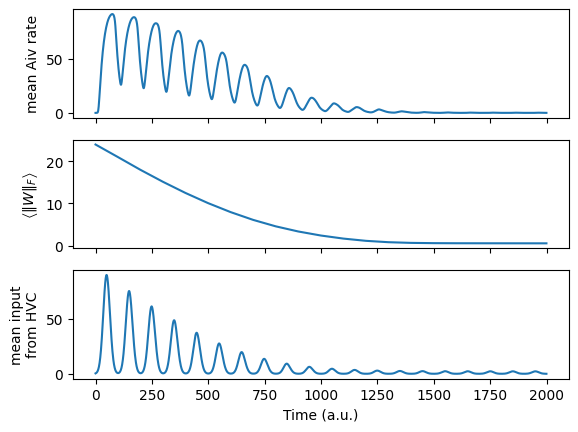

In [11]:
W_norms = np.array([np.linalg.norm(_, ord='fro') for _ in Ws]) # Frobenius norm
fig, ax = plt.subplots(3, sharex='all')
ax[0].plot(rA.mean(axis=1))
ax[1].plot(np.hstack([[0], save_W_ts]), W_norms)
ax[2].plot(mean_HVC_input)
ax[0].set(ylabel='mean Aiv rate')
ax[1].set(ylabel=r'$\left\langle \| W \|_F \right\rangle$')
ax[2].set(xlabel='Time (a.u.)', ylabel='mean input\nfrom HVC')

In [12]:
W_syl_corrs = [correlation(_.T, syl, lambda x: x) for _ in Ws]

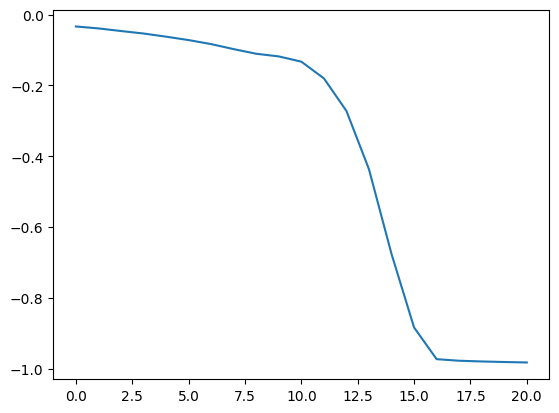

In [13]:
plt.plot(list(map(lambda x: x.flatten(), W_syl_corrs)))

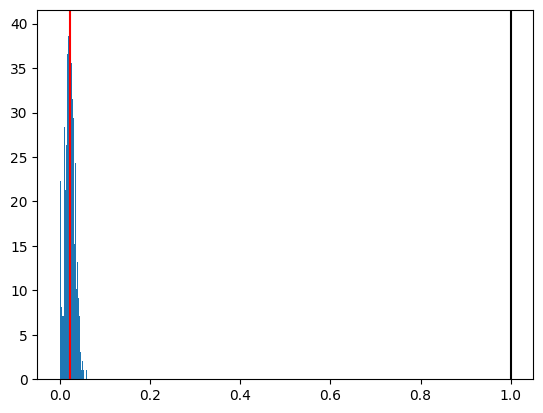

In [14]:
plt.hist(Ws[-1].flatten(), density=True, bins=30)
plt.axvline(Ws[-1].mean(), color='r')
plt.axvline(w0_mean, color='k')

## Error Code for Deterministic Perturbation

In [15]:
# Not used unless introduce multidimensional noise
eigvecs = np.linalg.qr(rng.random(size=(N_Aiv, N_Aiv)))[0]
eigvals = np.sort(rng.random(size=N_Aiv))[::-1]

In [16]:
def plot_sparse(ax, mat, th=0.1, clip_max=1):
    a_mat = np.abs(mat)
    rows, cols = np.where(a_mat > th)
    if len(rows) > 5000:
        idx = rng.choice(np.arange(0, len(rows)), size=2000, replace=False)
        rows, cols = rows[idx], cols[idx]
    colors = np.clip(a_mat[rows, cols], a_min=th, a_max=clip_max)
    ax.scatter(cols, rows, c=colors, s=1, cmap='binary')

### Single-node perturbation

In [17]:
Aiv0, I0 = np.ones(N_Aiv), 1
_T_rend = 200

rH_ = np.zeros((_T_rend, 1))
rH_[int(_T_rend//2):,:] = peak_rate

eps0s = np.linspace(0, 1, num=5)
_eps = 0.2
drA_deps = np.zeros((len(eps0s), _T_rend, N_Aiv, N_Aiv)) # rA dim first, then perturb dim
perturb = np.zeros(N_Aiv) + _eps

aud_ = np.tile(syl, (_T_rend, 1))
for i in tqdm(range(len(eps0s))):
    for j in range(N_Aiv):
        # noise = rng.standard_normal(size=(_T_rend, N_Aiv)) * 0
        
        perturb[[j-1,j]] = [_eps, eps0s[i]-0.05]
        _ = aud_ + perturb[None,:] #+ noise @ (eigvecs * np.sqrt(eigvals[:,None])).T
        res_l = net.sim(Aiv0, rH_, _, [], _T_rend, dt, 0)[0]
        
        perturb[[j-1,j]] = [_eps, eps0s[i]+0.05]
        _ = aud_ + perturb[None,:] #+ noise @ (eigvecs * np.sqrt(eigvals[:,None])).T
        res_r = net.sim(Aiv0, rH_, _, [], _T_rend, dt, 0)[0]
        
        drA_deps[i, :, :, j] = res_r - res_l
drA_deps /= 0.1

100%|█████████████████████████████████████████████| 5/5 [00:36<00:00,  7.39s/it]


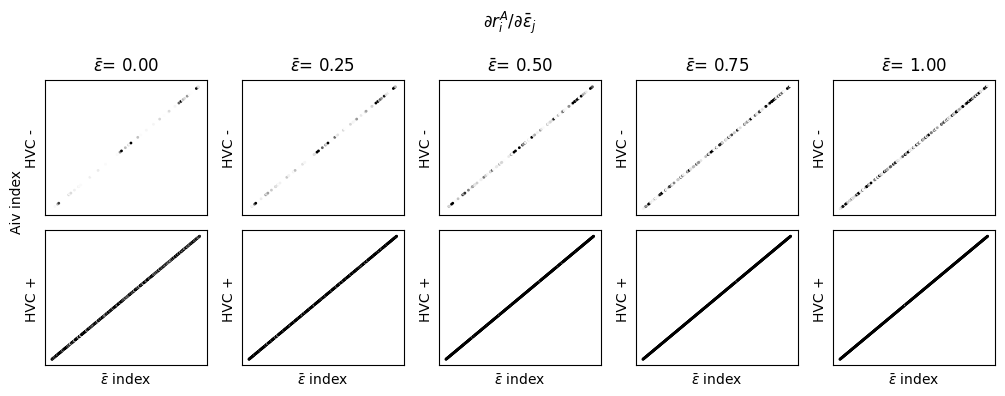

In [18]:
fig, ax = plt.subplots(2, len(eps0s), sharex='all', sharey='all', figsize=(10, 4))
for i in range(len(eps0s)):
    plot_sparse(ax[0,i], drA_deps[i, int(T_rend//2)-1], 0.05)
    plot_sparse(ax[1,i], drA_deps[i, -1], 0.05)
    # ax[0,i].spy(drA_deps[i, int(T_rend//2)-1], precision=0.1, color='k', markersize=1)
    # ax[1,i].spy(drA_deps[i, -1], precision=0.1, color='k', markersize=1)    
    ax[0,i].set(title=r'$\bar \epsilon$' + '= %.2f' % eps0s[i], xticks=[], yticks=[], ylabel='HVC -')
    ax[1,i].set(ylabel='HVC +', xlabel=r'$\bar \epsilon$ index')
fig.text(0, 0.5, 'Aiv index', rotation=90, verticalalignment='center')
fig.suptitle(r'$\partial r^A_i / \partial \bar \epsilon_j$')
fig.tight_layout()

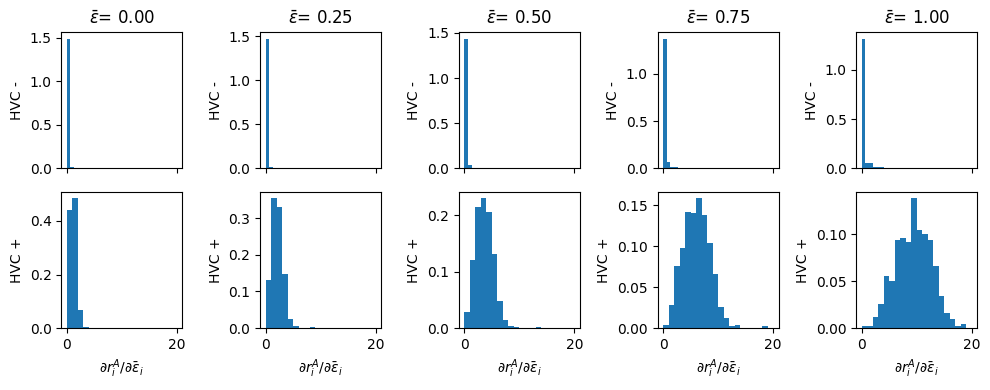

In [32]:
fig, ax = plt.subplots(2, len(eps0s), sharex='all', figsize=(10, 4))
for i in range(len(eps0s)):
    ax[0,i].hist(np.diag(drA_deps[i, int(T_rend//2)-1]), bins=30, range=(0, 20), density=True)
    ax[1,i].hist(np.diag(drA_deps[i, -1]), bins=20, range=(0, 20), density=True)
    ax[0,i].set(title=r'$\bar \epsilon$' + '= %.2f' % eps0s[i], ylabel='HVC -')
    ax[1,i].set(ylabel='HVC +', xlabel=r'$\partial r^A_i / \partial \bar \epsilon_i$')
fig.tight_layout()

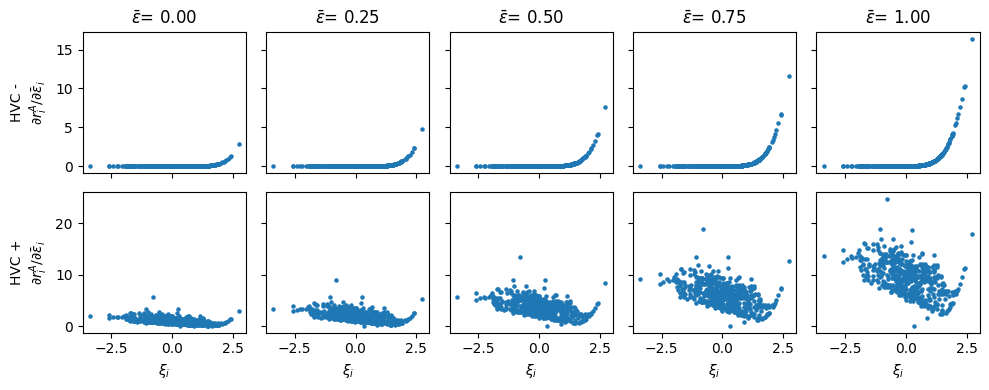

In [33]:
fig, ax = plt.subplots(2, len(eps0s), sharex='all', sharey='row', figsize=(10, 4))
for i in range(len(eps0s)):
    ax[0,i].scatter(syl[0], np.diag(drA_deps[i, int(T_rend//2)-1]), s=5)
    ax[1,i].scatter(syl[0], np.diag(drA_deps[i, -1]), s=5)
    ax[0,i].set(title=r'$\bar \epsilon$' + '= %.2f' % eps0s[i])
    ax[1,i].set(xlabel=r'$\xi_i$')
ax[0,0].set(ylabel='HVC -\n' + r'$\partial r^A_i / \partial \bar \epsilon_i$') 
ax[1,0].set(ylabel='HVC +\n' + r'$\partial r^A_i / \partial \bar \epsilon_i$')
fig.tight_layout()

## Error Code for the Eigenvalue of Perturbation Noise

In [21]:
perturb = 0

### Eigenvector has few zero elements

In [22]:
Aiv0, I0 = np.ones(N_Aiv), 1
_T_rend, rep = 500, 30 # repeat x times

rH_ = np.zeros((_T_rend, 1))
rH_[100:,:] = peak_rate

lams = np.linspace(0.1, 2, num=10)
drA_dlam = np.zeros((len(lams), _T_rend, N_Aiv, rep)) 

aud_ = np.tile(syl, (_T_rend, 1))
for i in tqdm(range(len(lams))):
    for j in range(rep):
        vec = np.ones(N_Aiv)
        # vec = rng.random(size=N_Aiv)
        vec /= np.linalg.norm(vec)
        noise = rng.standard_normal(size=(_T_rend, N_Aiv)) * vec

        _ = aud_ + perturb + noise * np.sqrt(lams[i]-0.05)
        res_l = net.sim(Aiv0, rH_, _, [], _T_rend, dt, 0)[0]
        
        _ = aud_ + perturb + noise * np.sqrt(lams[i]+0.05)
        res_r = net.sim(Aiv0, rH_, _, [], _T_rend, dt, 0)[0]
        
        drA_dlam[i, :, :, j] = res_r - res_l
drA_dlam /= 0.1

100%|███████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


In [23]:
bins = 30
lam_hist = np.zeros((len(lams), _T_rend, bins)) # hist for all drA/dlam
lam_std_hist = np.zeros((len(lams), 2, bins)) # hist for log stationary std
for i in range(len(lams)):
    for t in range(_T_rend):
        # Histogram across cells and simulations for each time step
        hist, be_der = np.histogram(drA_dlam[i,t].flatten(), bins=bins, 
                                    range=(-1e-2, 1e-2), density=True)
        lam_hist[i,t] = hist
    # Calc var across simulations and a few time steps towards the end
    # Then calc histogram
    _ = np.clip(np.log10(drA_dlam[i,90:100].std(axis=(-3,-1))), a_min=-4, a_max=0)
    hist, be_std_noHVC = np.histogram(_, bins=bins, range=(-4, -1), density=True)
    lam_std_hist[i,0] = hist
    _ = np.clip(np.log10(drA_dlam[i,-10:].std(axis=(-3,-1))), a_min=-4, a_max=0)
    hist, be_std_HVC = np.histogram(_, bins=bins, range=(-4, -1), density=True)
    lam_std_hist[i,1] = hist

/tmp/ipykernel_33841/3578118081.py:12: RuntimeWarning: divide by zero encountered in log10
  _ = np.clip(np.log10(drA_dlam[i,90:100].std(axis=(-3,-1))), a_min=-4, a_max=0)


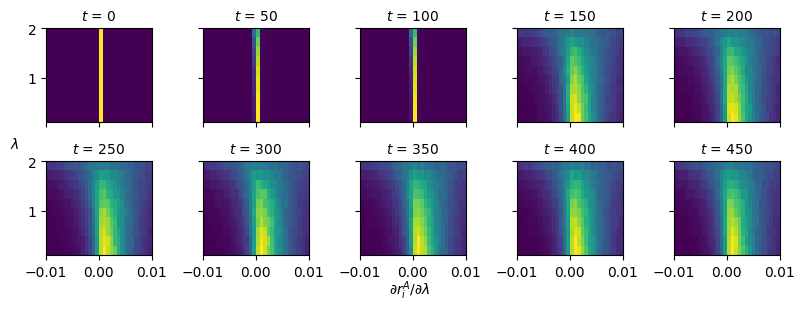

In [24]:
fig, ax = plt.subplots(2, 5, sharey='all', sharex='all', figsize=(8, 3))
ax = ax.flatten()
for i in range(len(ax)):
    ax[i].imshow(lam_hist[:,i*50,:], extent=(*be_der[[0,-1]], *lams[[0,-1]]), aspect='auto')
    ax[i].set_title(r'$t$' + ' = %d' % (i * 50), fontsize=10)
fig.text(0.5, 0, r'$\partial r^A_i/\partial \lambda$',
         horizontalalignment='center')
fig.text(0, 0.5, r'$\lambda$', verticalalignment='center')
fig.tight_layout()

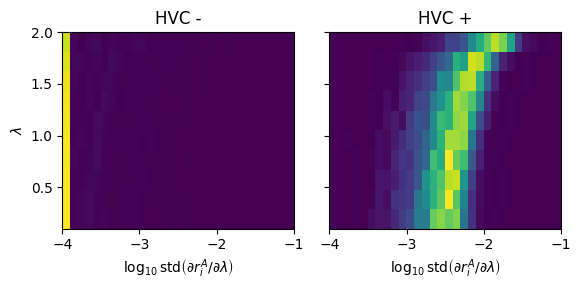

In [25]:
fig, ax = plt.subplots(1, 2, sharey='all', figsize=(6, 3))
ax[0].imshow(lam_std_hist[:,0,:], 
             extent=(*be_std_noHVC[[0,-1]], *lams[[0,-1]]), aspect='auto')
ax[1].imshow(lam_std_hist[:,1,:], 
             extent=(*be_std_HVC[[0,-1]], *lams[[0,-1]]), aspect='auto')
_ = r'$\log_{10}$std$\left(\partial r^A_i/\partial \lambda\right)$'
ax[0].set(xlabel=_, ylabel=r'$\lambda$', title='HVC -')
ax[1].set(xlabel=_, title='HVC +')
fig.tight_layout()

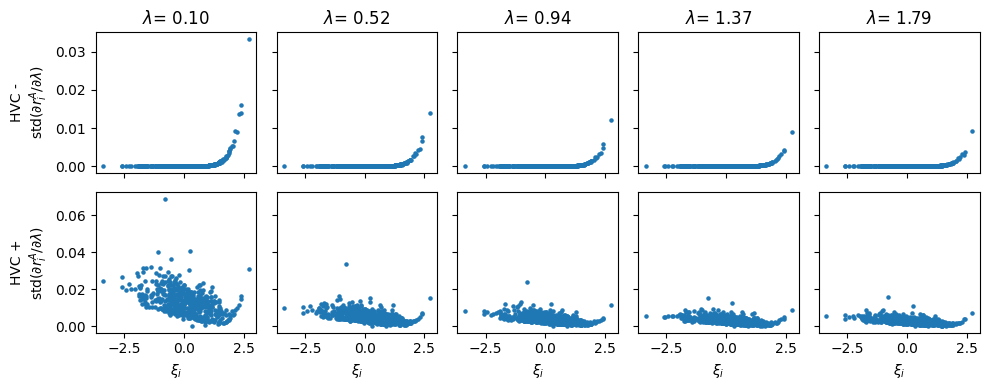

In [26]:
fig, ax = plt.subplots(2, int(len(lams)//2), sharex='all', sharey='row', figsize=(10, 4))
for i in range(int(len(lams)//2)):
    ax[0,i].scatter(syl[0], drA_dlam[i*2,90:100].std(axis=(-3,-1)), s=5)
    ax[1,i].scatter(syl[0], drA_dlam[i*2,-10:].std(axis=(-3,-1)), s=5)
    ax[0,i].set(title=r'$\lambda$' + '= %.2f' % lams[i*2])
    ax[1,i].set(xlabel=r'$\xi_i$')
ax[0,0].set(ylabel='HVC -\n' + r'std($\partial r^A_i / \partial \lambda$)') 
ax[1,0].set(ylabel='HVC +\n' + r'std($\partial r^A_i / \partial \lambda$)')
fig.tight_layout()

### Eigenvector has many zero elements (degenerate noise)

In [27]:
Aiv0, I0 = np.ones(N_Aiv), 1
_T_rend, rep = 500, 30 # repeat x times

rH_ = np.zeros((_T_rend, 1))
rH_[100:,:] = peak_rate

lams = np.linspace(0.1, 2, num=10)
drA_dlam = np.zeros((len(lams), _T_rend, N_Aiv, rep)) 

aud_ = np.tile(syl, (_T_rend, 1))
for i in tqdm(range(len(lams))):
    for j in range(rep):
        vec = np.zeros(N_Aiv)
        vec[:400] = 1 # Sparse eigenvec
        vec /= np.linalg.norm(vec)
        noise = rng.standard_normal(size=(_T_rend, N_Aiv)) * vec

        _ = aud_ + perturb + noise * np.sqrt(lams[i]-0.05)
        res_l = net.sim(Aiv0, rH_, _, [], _T_rend, dt, 0)[0]
        
        _ = aud_ + perturb + noise * np.sqrt(lams[i]+0.05)
        res_r = net.sim(Aiv0, rH_, _, [], _T_rend, dt, 0)[0]
        
        drA_dlam[i, :, :, j] = res_r - res_l
drA_dlam /= 0.1

100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


In [28]:
bins = 30
lam_hist = np.zeros((len(lams), _T_rend, bins)) # hist for all drA/dlam
lam_std_hist = np.zeros((len(lams), 2, bins)) # hist for log stationary std
for i in range(len(lams)):
    for t in range(_T_rend):
        # Histogram across cells and simulations for each time step
        hist, be_der = np.histogram(drA_dlam[i,t].flatten(), bins=bins, 
                                    range=(-1e-2, 1e-2), density=True)
        lam_hist[i,t] = hist
    # Calc var across simulations and a few time steps towards the end
    # Then calc histogram
    _ = np.clip(np.log10(drA_dlam[i,90:100].std(axis=(-3,-1))), a_min=-4, a_max=0)
    hist, be_std_noHVC = np.histogram(_, bins=bins, range=(-4, -1), density=True)
    lam_std_hist[i,0] = hist
    _ = np.clip(np.log10(drA_dlam[i,-10:].std(axis=(-3,-1))), a_min=-4, a_max=0)
    hist, be_std_HVC = np.histogram(_, bins=bins, range=(-4, -1), density=True)
    lam_std_hist[i,1] = hist

/tmp/ipykernel_33841/3578118081.py:12: RuntimeWarning: divide by zero encountered in log10
  _ = np.clip(np.log10(drA_dlam[i,90:100].std(axis=(-3,-1))), a_min=-4, a_max=0)
/tmp/ipykernel_33841/3578118081.py:15: RuntimeWarning: divide by zero encountered in log10
  _ = np.clip(np.log10(drA_dlam[i,-10:].std(axis=(-3,-1))), a_min=-4, a_max=0)


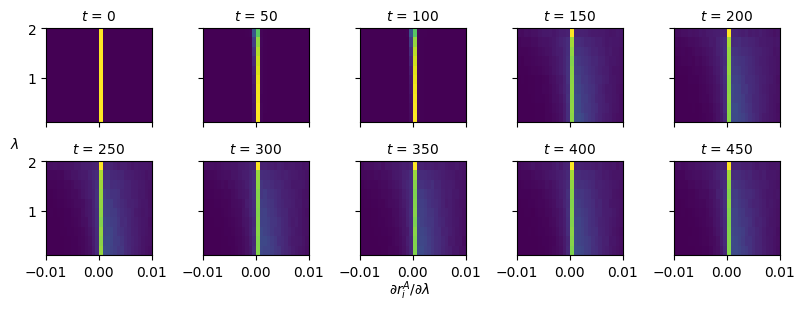

In [29]:
fig, ax = plt.subplots(2, 5, sharey='all', sharex='all', figsize=(8, 3))
ax = ax.flatten()
for i in range(len(ax)):
    ax[i].imshow(lam_hist[:,i*50,:], extent=(*be_der[[0,-1]], *lams[[0,-1]]), aspect='auto')
    ax[i].set_title(r'$t$' + ' = %d' % (i * 50), fontsize=10)
fig.text(0.5, 0, r'$\partial r^A_i/\partial \lambda$',
         horizontalalignment='center')
fig.text(0, 0.5, r'$\lambda$', verticalalignment='center')
fig.tight_layout()

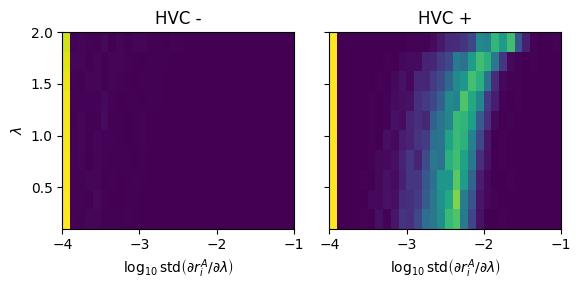

In [30]:
fig, ax = plt.subplots(1, 2, sharey='all', figsize=(6, 3))
ax[0].imshow(lam_std_hist[:,0,:], 
             extent=(*be_std_noHVC[[0,-1]], *lams[[0,-1]]), aspect='auto')
ax[1].imshow(lam_std_hist[:,1,:], 
             extent=(*be_std_HVC[[0,-1]], *lams[[0,-1]]), aspect='auto')
_ = r'$\log_{10}$std$\left(\partial r^A_i/\partial \lambda\right)$'
ax[0].set(xlabel=_, ylabel=r'$\lambda$', title='HVC -')
ax[1].set(xlabel=_, title='HVC +')
fig.tight_layout()

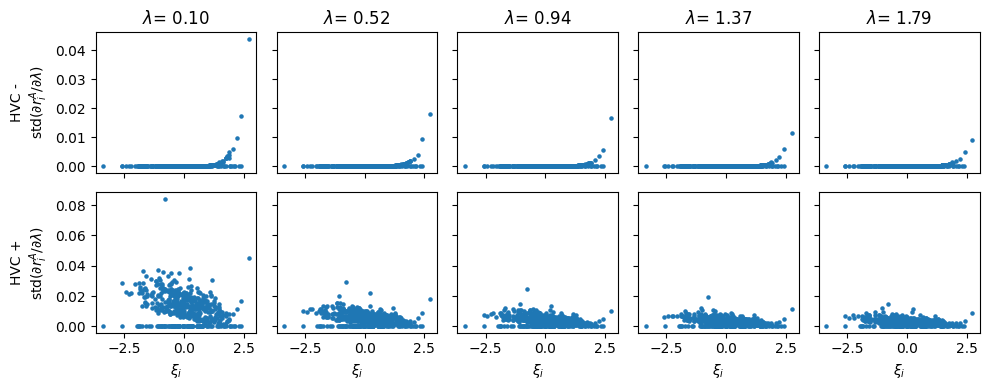

In [31]:
fig, ax = plt.subplots(2, int(len(lams)//2), sharex='all', sharey='row', figsize=(10, 4))
for i in range(int(len(lams)//2)):
    ax[0,i].scatter(syl[0], drA_dlam[i*2,90:100].std(axis=(-3,-1)), s=5)
    ax[1,i].scatter(syl[0], drA_dlam[i*2,-10:].std(axis=(-3,-1)), s=5)
    ax[0,i].set(title=r'$\lambda$' + '= %.2f' % lams[i*2])
    ax[1,i].set(xlabel=r'$\xi_i$')
ax[0,0].set(ylabel='HVC -\n' + r'std($\partial r^A_i / \partial \lambda$)') 
ax[1,0].set(ylabel='HVC +\n' + r'std($\partial r^A_i / \partial \lambda$)')
fig.tight_layout()